# Test on the loss function scaling in deep and shallow circuits

In [28]:
import numpy as np
import pennylane as qml
import torch as th

## Main test


In [172]:
def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

def generate_dm(N,L,p):

    dev = qml.device("lightning.qubit", wires=N)
    @qml.qnode(dev)
    def circuit(params, bool_ghz):
        """Build a circuit using repeated custom layers."""
        L,N = params.shape

        # Prepare GHZ state
        if bool_ghz:
            qml.Hadamard(wires=0)
            for i in range(1, N):
                qml.CNOT(wires=[0, i])

        for l in range(L):
            for n in range(N):
                qml.RX(params[l,n], wires=n)
            for i in range(N-1):
                qml.CNOT(wires=[i,i+1])
        return qml.state()
        
    dm_state = th.zeros(2**N,2**N, dtype=th.complex128)

    n_run = 100

    params = np.random.uniform(0, np.pi, size=(L, N))

    for _ in range(n_run):
        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        #print(entangle_flags)
        
        last_true_idx = np.where(entangle_flags)[0][-1] if np.any(entangle_flags) else 0        

        if last_true_idx<N:
            if last_true_idx == 0:
                bool_ghz = False
            else:
                bool_ghz = True
            #print("first",last_true_idx)
            l = last_true_idx   # number of effective layers 
            state = th.tensor(circuit(params[l:,:],bool_ghz))
        else:
            print("second",last_true_idx)
            state = th.zeros(2**N, dtype=th.complex128)
            state[0] = 1/np.sqrt(2)
            state[-1] = 1/np.sqrt(2)

        dm_state += th.outer(state.conj(), state)

    return dm_state / n_run

def calc_variance(N,L,p, n_sim=100):

    H = generate_H(N)

    res = []

    for _ in range(n_sim):
        
        state = generate_dm(N,L,p)

        # Run the circuit
        res.append(th.trace(state @ H).real)
    
    return np.mean(res),np.std(res)

In [175]:
calc_variance(4,2,0.)

(np.float64(-0.8953563289752888), np.float64(4.731380548220177))

### Circuit design

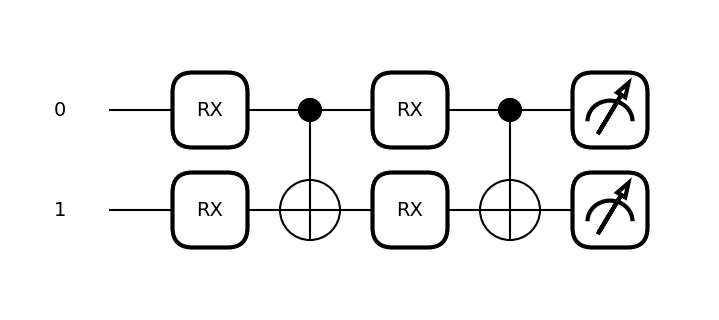

In [ ]:
N = 2

def generate_H(N):
    h = 9 / N
    scale = 2 ** (N / 2)

    coeffs = []
    observables = []

    for i in range(N - 1):
        op = qml.PauliZ(i) @ qml.PauliZ(i + 1)
        coeffs.append(1.0)  # You can scale later
        observables.append(op)

    H = qml.Hamiltonian([h * scale * c for c in coeffs], observables)
    return H

dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def circuit(params, bool_ghz):
        """Build a circuit using repeated custom layers."""
        L,N = params.shape

        # Prepare GHZ state
        if bool_ghz:
            qml.Hadamard(wires=0)
            for i in range(1, N):
                qml.CNOT(wires=[0, i])

        for l in range(L):
            for n in range(N):
                qml.RX(params[l,n], wires=n)
            for i in range(N-1):
                qml.CNOT(wires=[i,i+1])
        return qml.state()

params = np.ones((2, N)) 
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(params,False)

tensor([ 0.7071+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
         0.0000-0.5000j,  0.0000+0.0000j, -0.3536+0.0000j,  0.0000+0.3536j],
       dtype=torch.complex128)

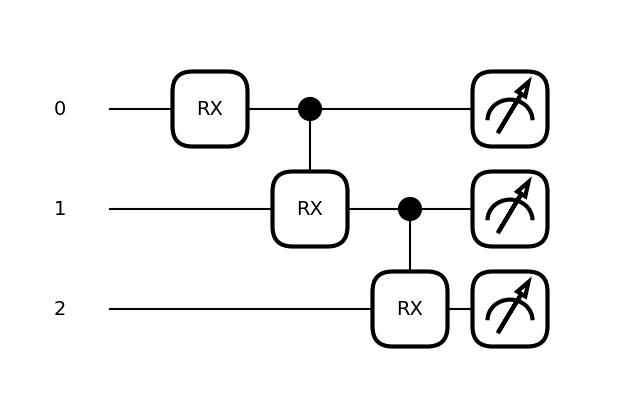

In [183]:
N = 3

dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def circuit():
        qml.RX(np.pi/2, wires=0)
        qml.CRX(np.pi/2, wires=[0,1])
        qml.CRX(np.pi/2, wires=[1,2])
        return qml.state()

params = np.ones((2, N)) 
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")()
th.tensor(circuit())